In [2]:
import numpy as np
import pandas as pd
import pandas_profiling # Use pandas_profiling.ProfileReport(df) instead of df.describe()
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, ADASYN

from collections import Counter
from psycopg2 import connect
from haversine import haversine

np.set_printoptions(suppress=True)

In [4]:
df = pd.read_pickle('df.pkl')

# Modeling

### Models to use:

KNN, Logistic Regression, Random Forest

In [5]:
df_y = df['is_late']
df_x = df.drop(columns = ['order_delivered_customer_date','order_estimated_delivery_date',
                          'customer_zip_code_prefix','seller_zip_code_prefix',
                          'is_late','order_id','customer_id','product_id','seller_id',
                          'order_purchase_timestamp','order_approved_at','shipping_limit_date',
                          'order_delivered_carrier_date'])
# Dropping all the non-numerical, date and y value from my x value of df
# Also dropping zip code because the model will not interpret that number correctly, and I already have lat/long

df_x.dtypes

price                float64
freight_value        float64
order_item_id          int64
product_weight_g     float64
product_length_cm    float64
product_height_cm    float64
product_width_cm     float64
product_vol_cm       float64
dist_km              float64
dtype: object

In [6]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y,
                                                    stratify = df_y,  # Include proportional y's in the splits
                                                    random_state = 37)

In [7]:
# Scale my features so that everything is in z-scores
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


## Logistic Regression

In [8]:
# Fitting and predicting with my Logistic Regression
logistic_model = LogisticRegression(random_state = 34, class_weight = 'balanced', n_jobs = -1)

logistic_model.fit(x_train_scaled, y_train)
logit_pred = logistic_model.predict(x_test_scaled)

print(metrics.f1_score(y_test, logit_pred), metrics.recall_score(y_test, logit_pred),
      metrics.precision_score(y_test, logit_pred))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


0.15937666017354346 0.42492917847025496 0.0980819529206626


**After I run all my models, I can go back in chat and find Han Wei's ensembling that he used**

In [63]:
# Define a confusion matrix function so that I can graph confusion matrices for each of my models
def confusion_matrix_graphic(prediction, real_y = y_test):
    conf_matrix = metrics.confusion_matrix(real_y, prediction)
    
    plt.figure(dpi=80)
    sns.heatmap(conf_matrix, cmap=plt.cm.Blues, annot=True, square=True, fmt = 'g',
               xticklabels=['Not late', 'Late'],
               yticklabels=['Not late', 'Late'])

    plt.xlabel('Predicted lateness')
    plt.ylabel('Actual lateness')
    plt.title('Confusion matrix');

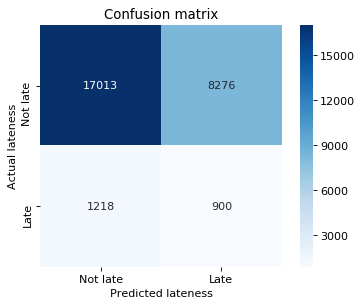

In [64]:
confusion_matrix_graphic(logit_pred)

## Recall vs precision:

My ideal model would classify all the late deliveries correctly from the not-late deliveries (~7.7% of the total are going to be late).

Since I am going to be proscribing reallocation of **special resources** to reduce late shipments, falsely identifying late shipments is worse than missing actual late shipments (Assumption: late shipments themselves aren't that bad, relative to changing our business around stopping late shipments incorrectly).

Overall, this means precision is more important than recall (I'd say precision is worth 60%, while recall is worth 40%). Roughly, this translates to English that a false positive on the margin is ~50% worse than missing a false negative (my business assumption)

In [11]:
print(classification_report(y_test, logit_pred))

              precision    recall  f1-score   support

       False       0.93      0.67      0.78     25289
        True       0.10      0.42      0.16      2118

   micro avg       0.65      0.65      0.65     27407
   macro avg       0.52      0.55      0.47     27407
weighted avg       0.87      0.65      0.73     27407



In [21]:
list(zip(x_train.columns, logistic_model.coef_[0]))

[('price', 0.029640339593967925),
 ('freight_value', -0.022320935114999507),
 ('order_item_id', -0.024800209127655792),
 ('product_weight_g', 0.07236802020549693),
 ('product_length_cm', 0.026236707553068287),
 ('product_height_cm', -0.003504973671806675),
 ('product_width_cm', -0.029780949565147857),
 ('product_vol_cm', 0.022499717970146074),
 ('dist_km', 0.2337960314426695)]

These results give preliminary evidence that latitude and longitude or both customer and seller are the most important general features of whether a shipment will be late or not.

Surprisingly, weight and volume and dimensions of the package seems to not matter much. What seems to matter a surprising amount is whether there was an additional item in the package (order_item_id). I decided to leave this metric in for possible insights like this - every additional package in an order decreases the likelihood of the package being delivered on time by 2.6%

In [22]:
# This cell calculates the logistic model's coefficient values, and turns it into interpretation
# Need to un-log these coefficients
readjusted_coefs = np.round((logistic_model.coef_[0] / scaler.scale_),8)

sorted(list(zip(abs(np.round(logistic_model.coef_[0], 8)),        # Abs val of the scaled coefficients
                            np.round(logistic_model.coef_[0], 8), # Val of the scaled coefficients
                            readjusted_coefs,                     # Unscaled val of coefficients (for interpretation)
                            x_test.columns)), reverse = True)     # Column labels

[(0.23379603, 0.23379603, 0.00039588, 'dist_km'),
 (0.07236802, 0.07236802, 1.939e-05, 'product_weight_g'),
 (0.02978095, -0.02978095, -0.0025547, 'product_width_cm'),
 (0.02964034, 0.02964034, 0.00016858, 'price'),
 (0.02623671, 0.02623671, 0.00163274, 'product_length_cm'),
 (0.02480021, -0.02480021, -0.03588523, 'order_item_id'),
 (0.02249972, 0.02249972, 9.6e-07, 'product_vol_cm'),
 (0.02232094, -0.02232094, -0.00142242, 'freight_value'),
 (0.00350497, -0.00350497, -0.00025957, 'product_height_cm')]

In [23]:
# Once I solve the shipping distance problem, I need to exponentiate to get the coefficients into log-odds.
# Then once I have log-odds, convert to probability

np.exp(0.039588)

1.0403820484769828

In [24]:
1.00039588**100

1.0403738981754433

In [25]:
df['dist_km'].mean()

# dist_km exponent is 0.00039588

596.4798573226084

**We see below that late deliveries are, on average, ~27% farther away than deliveries that are on time**

In [30]:
# We see that late deliveries are, on average, ~27% farther away than deliveries that are on time
print(df.loc[df['is_late'] == True, 'dist_km'].mean(), df.loc[df['is_late'] == False, 'dist_km'].mean())

print((740.5 - 584.4) / 584.4)

740.48965973958 584.4200774177633
0.2671115674195757


**I may want to include in my presentation that in my old model, I calculated the change in odds by 1 km on the margin. But I cannot extrapolate that to 1 * 100. Instead I need to recalculate my model based on every 100 km. My log-odd coefficients will be exactly 100x the old coefficients, but when I *exponentiate* that, the amount is sliiiiightly different. This is the change in probability that is compounded from 1 to 100, very similarly to compound interest.**

For example, if I had 12% interest compounded yearly, compared to 1% interest compounded monthly, 1% would be more. But a slightly smaller percentage (0.97% for instance) would be equal. My old 1 km calculation was the old, smaller percentage, and the 100 km calculation was the bigger, 12% calculation

## K-Nearest Neighbors

In [28]:
# ### Manual Cross Fold Validation for Hyper Parameter Tuning- KNN
# k_range = range(10,)
# all_scores = []
# for x in k_range:
#     knn = KNeighborsClassifier(n_neighbors=x)
#     scores = cross_val_score(knn, x_train_scaled, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
#     all_scores.append(np.mean(scores))
# best_index = np.argmax(all_scores)
# print(f'The best hyper parameters are: {k_range[best_index]}')
# print(f'The best score is: {all_scores[best_index]}')

In [32]:
knn = KNeighborsClassifier(n_jobs = -1)

param_grid = {'n_neighbors': [i ** 2 for i in range(7,11)]} # Gridsearching through squared values to find ideal KNN
knn_best = GridSearchCV(knn, param_grid, cv = 3, scoring = 'roc_auc')

knn_best.fit(x_train_scaled, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [49, 64, 81, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [33]:
print(knn_best.best_params_, knn_best.best_score_, knn_best.best_estimator_)

{'n_neighbors': 81} 0.5758900801265783 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=81, p=2,
           weights='uniform')


The above shows that the best n-neighbor parameters for my model are 81, and that my roc_auc scoring is 0.5759 (slightly better than the 0.5 that would be from random guessing)

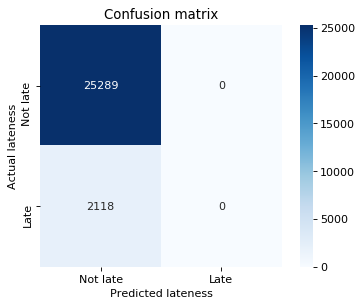

In [65]:
# Run the prediction and confusion matrix function that I defined
knn_pred = knn_best.best_estimator_.predict(x_test_scaled) # Take the best KNN that was found above

confusion_matrix_graphic(knn_pred)

We can see that this version of KNN was terrible. It had reasonable precision, but very very low recall

## Oversampling

In [57]:
# SMOTE
x_train_smoted, y_train_smoted = SMOTE(random_state=37).fit_sample(x_train_scaled, y_train)

In [42]:
Counter(y_smoted)

Counter({False: 75866, True: 75866})

In [58]:
# ADASYN
x_train_adasyn, y_train_adasyn = ADASYN(random_state = 37).fit_sample(x_train_scaled,y_train)

### KNN SMOTE

In [59]:
knn = KNeighborsClassifier(n_jobs = -1)

param_grid = {'n_neighbors': [i for i in range(1,10)]} # Gridsearching through squared values to find ideal KNN
knn_smote_best = GridSearchCV(knn, param_grid, cv = 3, scoring = 'roc_auc')

knn_smote_best.fit(x_train_smoted, y_train_smoted)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [60]:
print(knn_smote_best.best_params_, knn_smote_best.best_score_, knn_smote_best.best_estimator_)

{'n_neighbors': 4} 0.9172140993456895 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
           weights='uniform')


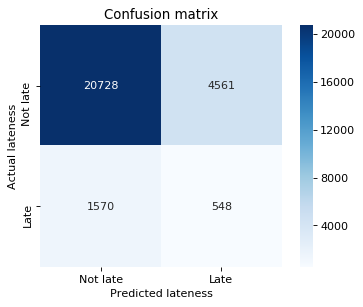

In [66]:
# Run the prediction and confusion matrix function that I defined
knn_smote_pred = knn_smote_best.best_estimator_.predict(x_test_scaled) # Take the best KNN that was found above

confusion_matrix_graphic(knn_smote_pred)

SMOTE is better than ADASYN in my tests. I will delete ADASYN and use SMOTE from now on rather than ADASYN

## Random Forest

In [85]:
# Running the GridSearch to find roughly the best model for my Random Forest
rf = RandomForestClassifier(oob_score = True, n_jobs = -1, random_state = 37)


param_grid = {'n_estimators': [i * 10 for i in range(1,3)],
              'max_depth' : [i ** 2 for i in range (7,15)]}

rf_best = GridSearchCV(rf, param_grid, cv = 3, scoring = 'roc_auc', verbose = 30)

rf_best.fit(x_train_smoted, y_train_smoted)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] max_depth=49, n_estimators=10 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=49, n_estimators=10, score=0.9423221890819388, total=   3.0s
[CV] max_depth=49, n_estimators=10 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=49, n_estimators=10, score=0.9769891741139867, total=   3.5s
[CV] max_depth=49, n_estimators=10 ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.0s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=49, n_estimators=10, score=0.9768101602409587, total=   3.4s
[CV] max_depth=49, n_estimators=20 ...................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.7s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=49, n_estimators=20, score=0.9511928812563368, total=   5.8s
[CV] max_depth=49, n_estimators=20 ...................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   16.9s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=49, n_estimators=20, score=0.9843351909305158, total=   4.9s
[CV] max_depth=49, n_estimators=20 ...................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.1s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=49, n_estimators=20, score=0.9836423502797912, total=   4.4s
[CV] max_depth=64, n_estimators=10 ...................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   26.8s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=64, n_estimators=10, score=0.9411954952084521, total=   2.5s
[CV] max_depth=64, n_estimators=10 ...................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   29.5s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=64, n_estimators=10, score=0.9773471928768532, total=   2.3s
[CV] max_depth=64, n_estimators=10 ...................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   32.1s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=64, n_estimators=10, score=0.976545966329948, total=   2.2s
[CV] max_depth=64, n_estimators=20 ...................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   34.5s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=64, n_estimators=20, score=0.9502488658448289, total=   4.7s
[CV] max_depth=64, n_estimators=20 ...................................


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   39.6s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=64, n_estimators=20, score=0.983986686915196, total=   4.5s
[CV] max_depth=64, n_estimators=20 ...................................


[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:   44.5s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=64, n_estimators=20, score=0.9833246780073623, total=   4.4s
[CV] max_depth=81, n_estimators=10 ...................................


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   49.2s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=81, n_estimators=10, score=0.9413169790673099, total=   2.2s
[CV] max_depth=81, n_estimators=10 ...................................


[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:   51.6s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=81, n_estimators=10, score=0.9773471928768532, total=   2.1s
[CV] max_depth=81, n_estimators=10 ...................................


[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   53.9s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=81, n_estimators=10, score=0.976545966329948, total=   2.0s
[CV] max_depth=81, n_estimators=20 ...................................


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   56.2s remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=81, n_estimators=20, score=0.9502409546097897, total=   4.1s
[CV] max_depth=81, n_estimators=20 ...................................


[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  1.0min remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=81, n_estimators=20, score=0.983986686915196, total=   3.8s
[CV] max_depth=81, n_estimators=20 ...................................


[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:  1.1min remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=81, n_estimators=20, score=0.9833246772254807, total=   3.6s
[CV] max_depth=100, n_estimators=10 ..................................


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.1min remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=100, n_estimators=10, score=0.9413169790673099, total=   2.1s
[CV] max_depth=100, n_estimators=10 ..................................


[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:  1.2min remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=100, n_estimators=10, score=0.9773471936586731, total=   2.0s
[CV] max_depth=100, n_estimators=10 ..................................


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.2min remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=100, n_estimators=10, score=0.976545966329948, total=   2.0s
[CV] max_depth=100, n_estimators=20 ..................................


[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:  1.3min remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=100, n_estimators=20, score=0.9502409546097897, total=   4.0s
[CV] max_depth=100, n_estimators=20 ..................................


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:  1.3min remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=100, n_estimators=20, score=0.983986686915196, total=   4.2s
[CV] max_depth=100, n_estimators=20 ..................................


[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:  1.4min remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=100, n_estimators=20, score=0.9833246780073623, total=   4.0s
[CV] max_depth=121, n_estimators=10 ..................................


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  1.5min remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=121, n_estimators=10, score=0.9413169790673099, total=   2.3s
[CV] max_depth=121, n_estimators=10 ..................................


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.5min remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=121, n_estimators=10, score=0.9773471936586731, total=   2.1s
[CV] max_depth=121, n_estimators=10 ..................................


[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:  1.6min remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=121, n_estimators=10, score=0.976545966329948, total=   2.9s
[CV] max_depth=121, n_estimators=20 ..................................


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  1.6min remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=121, n_estimators=20, score=0.9502409546097897, total=   5.2s
[CV] max_depth=121, n_estimators=20 ..................................


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:  1.7min remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=121, n_estimators=20, score=0.9839866869151961, total=   4.9s
[CV] max_depth=121, n_estimators=20 ..................................


[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:  1.8min remaining:    0.0s
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=121, n_estimators=20, score=0.9833246780073623, total=   4.9s
[CV] max_depth=144, n_estimators=10 ..................................


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=144, n_estimators=10, score=0.9413169790673099, total=   2.8s
[CV] max_depth=144, n_estimators=10 ..................................


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=144, n_estimators=10, score=0.9773471928768532, total=   2.6s
[CV] max_depth=144, n_estimators=10 ..................................


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=144, n_estimators=10, score=0.976545966329948, total=   2.4s
[CV] max_depth=144, n_estimators=20 ..................................


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=144, n_estimators=20, score=0.9502409546097897, total=   5.2s
[CV] max_depth=144, n_estimators=20 ..................................


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=144, n_estimators=20, score=0.983986686915196, total=   5.1s
[CV] max_depth=144, n_estimators=20 ..................................


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=144, n_estimators=20, score=0.9833246780073623, total=   5.1s
[CV] max_depth=169, n_estimators=10 ..................................


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=169, n_estimators=10, score=0.9413169790673099, total=   2.9s
[CV] max_depth=169, n_estimators=10 ..................................


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=169, n_estimators=10, score=0.9773471928768532, total=   2.8s
[CV] max_depth=169, n_estimators=10 ..................................


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=169, n_estimators=10, score=0.976545966329948, total=   2.7s
[CV] max_depth=169, n_estimators=20 ..................................


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=169, n_estimators=20, score=0.9502409546097897, total=   6.1s
[CV] max_depth=169, n_estimators=20 ..................................


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=169, n_estimators=20, score=0.983986686915196, total=   5.7s
[CV] max_depth=169, n_estimators=20 ..................................


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=169, n_estimators=20, score=0.9833246780073623, total=   5.3s
[CV] max_depth=196, n_estimators=10 ..................................


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=196, n_estimators=10, score=0.9413169790673099, total=   3.0s
[CV] max_depth=196, n_estimators=10 ..................................


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=196, n_estimators=10, score=0.9773471936586731, total=   3.0s
[CV] max_depth=196, n_estimators=10 ..................................


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=196, n_estimators=10, score=0.976545966329948, total=   2.9s
[CV] max_depth=196, n_estimators=20 ..................................


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=196, n_estimators=20, score=0.9502409546097897, total=   6.2s
[CV] max_depth=196, n_estimators=20 ..................................


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=196, n_estimators=20, score=0.9839866869151961, total=   6.3s
[CV] max_depth=196, n_estimators=20 ..................................


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[CV]  max_depth=196, n_estimators=20, score=0.9833246772254807, total=   5.8s


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  3.2min finished
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=True, random_state=37, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 20], 'max_depth': [49, 64, 81, 100, 121, 144, 169, 196]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=30)

In [86]:
print(rf_best.best_params_, rf_best.best_score_, rf_best.best_estimator_)

{'max_depth': 49, 'n_estimators': 20} 0.9730566679594111 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=49, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=True, random_state=37, verbose=0, warm_start=False)


In [87]:
# Why do I keep running into my model predicting not late for all shipments?
rf_best.best_estimator_.predict(x_test).shape

(27407,)

{'max_depth': 81}

**Need to choose between using ROC_AUC and F1_Score to score my model when I am making it.**

Conceptually, the ROC_AUC maximizes your model's performance at all levels of threshold (At one corner, it'll classify positives when it is 0.01 confident, at the other corner it will only classify upon 0.99 confidence. Everything else in the middle operates on some spectrum of confidence. That spectrum of confidence will result in different False Positive and False Negative rates, and you have to choose where your *actual model* classifies based on your preferences: precision, recall, sensitivity, specificity)

Conceptually, the F1_Score finds the harmonic mean of your optimized precision and recall. To compare it with the ROC_AUC scoring, it'll score your model by picking the threshold that maximizes the harmonic mean between precision and recall, rather than providing the expected results at every threshold (It'll simply pick "the best" threshold, given the weights that you assign to precision and recall, with a default of a 50/50 split)

Jonathan recommends Random Forest for my problem - I'm likely to have late shipments overlapping with not late shipments, without any way to separate them in my dataset.